# Preprocessing
This file contains some preprocessing steps

## Load the data

In [149]:
import pandas as pd

news_articles = pd.read_csv("../dataset/data.csv")

print(news_articles.dtypes, news_articles.shape)
news_articles.head()

label       int64
title      object
text       object
subject    object
date       object
dtype: object (39942, 5)


,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Deeper data evaluation

In [150]:
# check for missing values
print(news_articles.isnull().sum())

# Understand the data
print("Unique label values:", news_articles.label.unique())
print("Unique subject values:", news_articles.subject.unique())

# Check for empty strings
empty_title = news_articles[news_articles['title'].str.strip() == '']
empty_text = news_articles[news_articles['text'].str.strip() == '']
empty_subject = news_articles[news_articles['subject'].str.strip() == '']
empty_date = news_articles[news_articles['date'].str.strip() == '']

print(f"Empty titles: {len(empty_title)}")
print(f"Empty texts: {len(empty_text)}")
print(f"Empty subjects: {len(empty_subject)}")
print(f"Empty dates: {len(empty_date)}")


# Check for duplicated articles
print("Duplicated entries:", news_articles.duplicated(subset=["label", 'title', 'text']).sum())


label      0
title      0
text       0
subject    0
date       0
dtype: int64
Unique label values: [1 0]
Unique subject values: ['politicsNews' 'worldnews' 'News' 'politics' 'Government News'
 'left-news']
Empty titles: 0
Empty texts: 610
Empty subjects: 0
Empty dates: 0
Duplicated entries: 3513


## Data cleaning
### Basic data cleaning

In [151]:
# Remove duplicates and keep the first one
news_articles = news_articles.drop_duplicates(subset=["label", 'title', 'text'])

# Remove articles with empty text
news_articles = news_articles[news_articles["text"].str.strip() != ""]

# One Hot encoding for subject column
news_articles = pd.get_dummies(news_articles, columns=["subject"])

# Combine both text columns
news_articles["title_text"] = news_articles["title"] + news_articles["text"]
news_articles.drop(columns=["title", "text"], inplace=True)

news_articles.shape

(35989, 9)

### Handle dates

In [152]:
from datetime import datetime

#  Strip empty spaces from date values
news_articles['date'] = news_articles['date'].str.strip()

def parse_date(date_text):
    """
    Attempts to parse a date string into a datetime object using multiple formats.
    If none of the formats match, returns pd.NaT to indicate a missing datetime.
    
    Parameters:
        date_text (str): The date string to parse.
        
    Returns:
        datetime or pd.NaT (Not a time)
    """
    for format in ("%B %d, %Y", "%b %d, %Y", "%d-%b-%y"):
        try:
            return datetime.strptime(date_text, format)
        except Exception:
            # Try next format
            continue
    return pd.NaT

# Convert date column to date-time format
news_articles['date'] = news_articles["date"].apply(parse_date)

# Remove rows with non parsable date format
news_articles = news_articles[news_articles["date"].isna() == False]

# Handle date column and prevent temporal leakage
news_articles['year'] = news_articles['date'].dt.year
news_articles['month'] = news_articles['date'].dt.month
news_articles['day'] = news_articles['date'].dt.day

news_articles.drop(columns=["date"], inplace=True)

news_articles.head()

,label,subject_Government News,subject_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews,title_text,year,month,day
0,1,False,False,False,False,True,False,"As U.S. budget fight looms, Republicans flip t...",2017,12,31
1,1,False,False,False,False,True,False,U.S. military to accept transgender recruits o...,2017,12,29
2,1,False,False,False,False,True,False,Senior U.S. Republican senator: 'Let Mr. Muell...,2017,12,31
3,1,False,False,False,False,True,False,FBI Russia probe helped by Australian diplomat...,2017,12,30
4,1,False,False,False,False,True,False,Trump wants Postal Service to charge 'much mor...,2017,12,29


## Train / Test Split
Perform train / test split before text preprocessing to avoid data leakage.<br />
This ensures that no information from the test set influences the preprocessing steps.

In [153]:
from sklearn.model_selection import train_test_split

y = news_articles["label"]
X = news_articles.drop(columns=["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

## Preprocess text columns

In [154]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()

def text_preprocessing_pipeline(text):
    """
    Preprocesses a text string by applying standard NLP cleaning steps:
    tokenization, stop word removal, punctuation removal, and lemmatization.

    Parameters:
        text (str): The input text string to preprocess.

    Returns:
        str: A cleaned and lemmatized string with tokens joined by spaces.
    """
    # Tokenize the text
    tokenized_text = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [w for w in tokenized_text if w.lower() not in stop_words]

    # Remove punctuation
    filtered_tokens = [w for w in filtered_tokens if w not in string.punctuation]

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return " ".join(lemmatized_tokens)

X_train["title_text"] = X_train["title_text"].apply(text_preprocessing_pipeline)

In [155]:
X_train.head()

,subject_Government News,subject_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews,title_text,year,month,day
22521,False,True,False,False,False,False,37 mental health worker begging congress impea...,2017,2,15
1007,False,False,False,False,True,False,u.s. envoy haley make emotional visit congo di...,2017,10,26
2940,False,False,False,False,True,False,trump discusses gulf-qatar dispute erdogan whi...,2017,6,30
19771,False,False,False,False,False,True,norwegian policeman jailed 21 year drug caseos...,2017,9,18
33254,False,False,False,True,False,False,oops new app allows user remain anonymous…defi...,2016,8,13


## Visualization

label
1    19788
0    16195
Name: count, dtype: int64


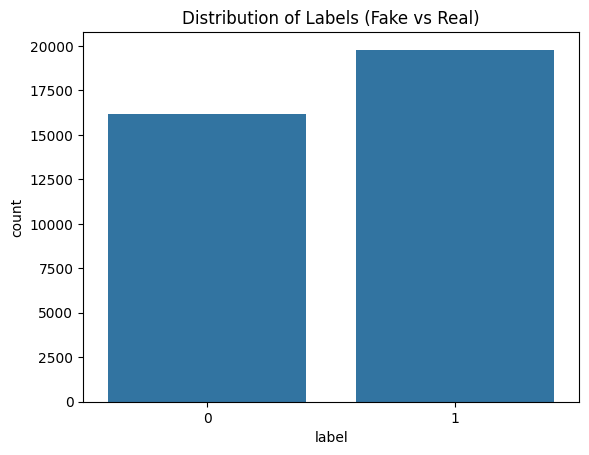

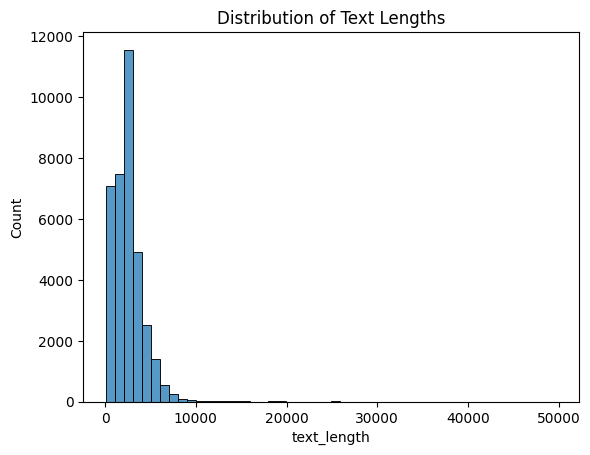

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable (label)
print(news_articles['label'].value_counts())
sns.countplot(x='label', data=news_articles)
plt.title('Distribution of Labels (Fake vs Real)')
plt.show()

# Add a new column 'text_length'
news_articles['text_length'] = news_articles['title_text'].apply(lambda x: len(x))

# Length of the texts (tokens)
sns.histplot(news_articles['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.show()

# Remove column, it is not needed anymore
news_articles.drop(columns=["text_length"], inplace=True)